# Import Libraries

In [183]:
import numpy as np         
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Importing the libraries for WordCloud
from wordcloud import WordCloud, STOPWORDS
import re 
from nltk.stem import PorterStemmer # For stemming
from bs4 import BeautifulSoup # For removing HTML tags

# Create a folder to store the figures.

In [184]:
# create a folder to store the figures
fig_folder = "png"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Data Reading

In [185]:
data = pd.read_csv('../data/train.csv') # read the data
print(f'The number of datapoints is {data.shape}')
data.head(5) # show the first 5 rows

The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Data Description

In [186]:
data.info()     # display the data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Drop Null Data(First Check)


In [187]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [188]:
data = data.dropna()            # drop all rows with null values
data.shape

(404287, 6)

# Exploratory Data Analysis

## The distribution of duplicated and Non-duplicated questions

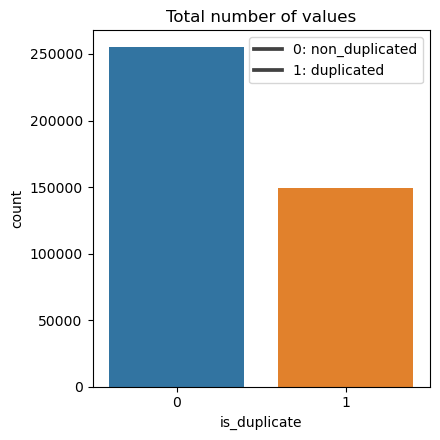

After droping missing values
Total number of question pairs is 404287
Duplicated Questions is 149263, which is 37% of total
Non-Duplicated Questions is 255024, which is 63 % of total


In [189]:
# plotting the number of duplicate pairs and different pairs
plt.figure(figsize=(4.5,4.5))
ct = data['is_duplicate'].value_counts() # count the number of duplicate pairs
sns.barplot(x=ct.index,y=ct.values) # plot the barplot
plt.title('Total number of values')
plt.xlabel('is_duplicate')
plt.ylabel('count')
plt.legend(['0: non_duplicated', '1: duplicated']) 
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'duplicate.png'), dpi=450)
plt.show()

print('After droping missing values')
print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Duplicated Questions is {}, which is {}% of total'.format(ct[1],round((ct[1]/len(data.id.values)*100)),2))
print('Non-Duplicated Questions is {}, which is {} % of total'.format(ct[0],round((ct[0]/len(data.id.values)*100)),2))

## Uniques questions & Repeated questions
In this section, we check the number of unique questions and repeated questions in the dataset.

In [190]:
# Combine the questions of question1 and question2
total_q= pd.Series(data.question1.tolist() + data.question2.tolist())
print(f'Total questions is {len(total_q)}')
print(total_q.head())
unique_q = np.unique(total_q) # extract unique questions from total questions
num_unique_q = len(unique_q) # Number of unique questions
print(f'Unique questions is {num_unique_q}')

# Count the number of times each question occured
cnt = total_q.value_counts().sort_values(ascending=False)
once = len(cnt[cnt.values == 1]) # Just once
atleast2 = len(cnt[cnt.values >= 2]) # Atleast 2 times
max_cnt = max(cnt) # The number of occurance for the most frequent question

Total questions is 808574
0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object
Unique questions is 537359


In [191]:
print(f'Once: {once}, Atleast2: {atleast2}')
print(num_unique_q == (once + atleast2)) # check the consistency
print(cnt.head()) # Top 5 most occuring questions
print(f"The percentage of quesions that occured more than once is {round((atleast2/num_unique_q)*100,1)}%")
print(f'Max occurance of a question is {max_cnt}') # Max occurance of a question


Once: 425489, Atleast2: 111870
True
What are the best ways to lose weight?                                             161
How can you look at someone's private Instagram account without following them?    120
How can I lose weight quickly?                                                     111
What's the easiest way to make money online?                                        88
Can you see who views your Instagram?                                               79
dtype: int64
The percentage of quesions that occured more than once is 20.8%
Max occurance of a question is 161


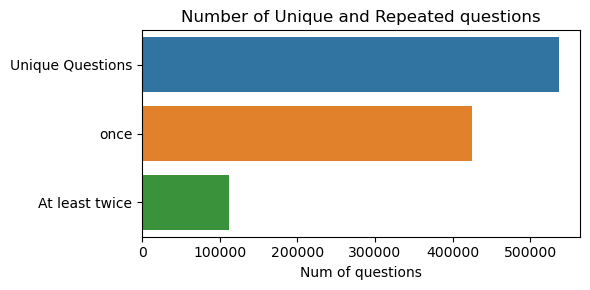

In [192]:
# Compare the number of unique and repeated questions
plt.figure(figsize=(6.0,3.0))
qts = pd.Series(data=['Unique Questions','once','At least twice'], index=[num_unique_q, once, atleast2])
sns.barplot(x=qts.index, y=qts.values)
plt.title('Number of Unique and Repeated questions')
plt.xlabel('Num of questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Unique_repeated_quesions.png'), dpi=450)
plt.show()

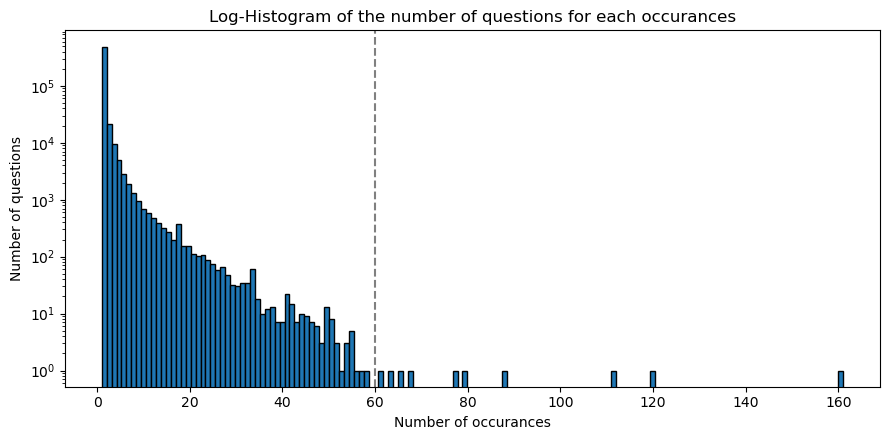

In [193]:
# Plot the histogram of the number of questions for each occurances
plt.figure(figsize=(9, 4.5))
plt.hist(cnt,edgecolor='black', bins=150)
plt.axvline(x=60, color='gray', linestyle='--')
plt.yscale('log')
plt.title('Log-Histogram of the number of questions for each occurances')
plt.xlabel('Number of occurances')
plt.ylabel('Number of questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Log_Histogram_of_question_occurances.png'), dpi=450)
plt.show()

## The distribution of word count in questions

In [194]:
word_counts = total_q.str.split().apply(lambda x: len(x))
print(word_counts.head())
print(word_counts.describe())
word_counts_dist = word_counts.value_counts()

0    14
1     8
2    14
3    11
4    13
dtype: int64
count    808574.000000
mean         11.062137
std           5.884570
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64


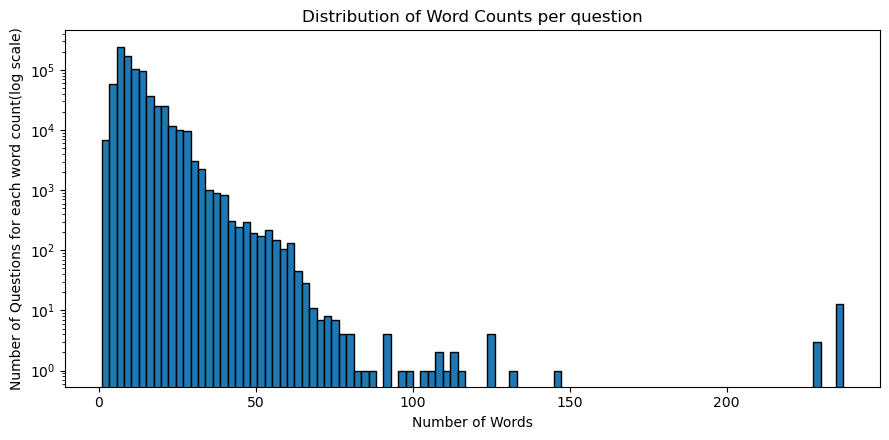

In [195]:
# Plot the distribution of word counts per question.
plt.figure(figsize=(9, 4.5))
plt.hist(word_counts, bins=100, edgecolor='black')
plt.yscale('log') # log scale
plt.title("Distribution of Word Counts per question")
plt.xlabel("Number of Words")
plt.ylabel("Number of Questions for each word count(log scale)")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_count_dist.png'), dpi=450)
plt.show()

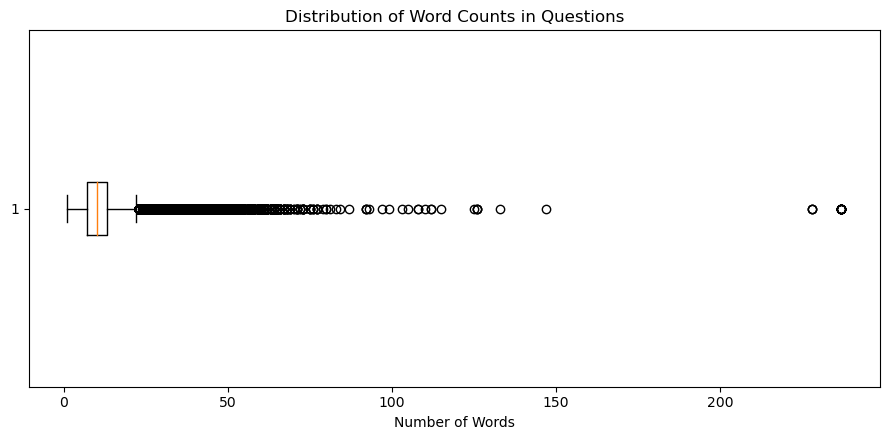

In [196]:
# Plot the boxplot of word counts per question.
plt.figure(figsize=(9, 4.5))
plt.boxplot(word_counts, vert=False)
plt.title("Distribution of Word Counts in Questions")
plt.xlabel("Number of Words")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_count_dist(boxplot).png'), dpi=450)
plt.show()

In [197]:
# print the question that contatins the most words
print(total_q[word_counts == max(word_counts)].head())
# check whether or not all the questions that contain 237 words are all indential to each other
np.all(total_q[word_counts == max(word_counts)].values == total_q[word_counts == max(word_counts)].values[0])


422342    Heartbreak? Heartbreak? She's my girlfriend fo...
456234    Heartbreak? Heartbreak? She's my girlfriend fo...
480014    Heartbreak? Heartbreak? She's my girlfriend fo...
498763    Heartbreak? Heartbreak? She's my girlfriend fo...
522868    Heartbreak? Heartbreak? She's my girlfriend fo...
dtype: object


True

According to the above output, they are all indential to each other.

# Feature Engineering

In order to further understand the dataset, we reconstruct the data and add some new features:
 - ____word_Common____ = (Number of unique common unique words in Question 1 and Question 2) -> The intersection of the two questions
  
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2) -> The union of the two questions
     
 - ____word_share____ = (word_common)/(word_Total), namely the similarity between the two questions. -> The similarity between the two questions


### Motivation for "word_share" feature
The motivation behind these new features is that we can intuitively predict that duplicated questions will have more words in common.


In [198]:
if os.path.isfile('data_after_dropout_null'):
    data = pd.read_csv("data_after_dropout_null",encoding='latin-1')
else:
    # intersection of two sets
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y) 

    # union of two sets
    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))
    
    # the ratio of common words to total words
    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x 

data['word_common'] = data.apply(common_wrd,axis=1)
data['word_total'] = data.apply(total,axis=1)
data['word_share'] = data.apply(word_share,axis=1)

# save the data to csv file
data.to_csv("../data/data_after_dropout_null.csv", index=False)

## New datasheet
As you can see, word_common, word_total, word_share are added to the original dataset.

In [199]:
data = pd.read_csv('../data/data_after_dropout_null.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2.0,20.0,0.100000


### Common words in duplicatd questions and non-duplicated questions.

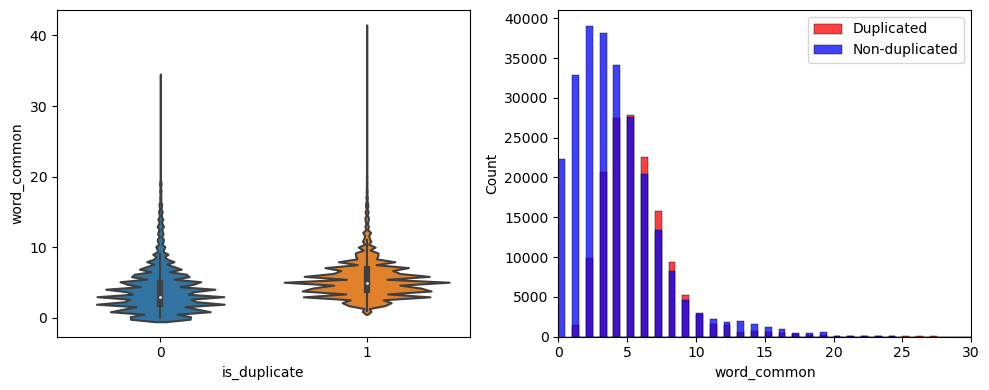

In [200]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='Duplicated',binwidth=0.5)
sns.histplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='Non-duplicated',binwidth=0.5)
plt.legend()
plt.xlim(0,30)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_common.png'), dpi=450)
plt.show()

### Shared words
From the following diagram, we can notice that as the word share increases there is a higher chance the questions are similar. From the histogram, we can understand that word share has some information differentiating similar and dissimilar classes. This trend matches the intuition that similar questions will have more words in common.

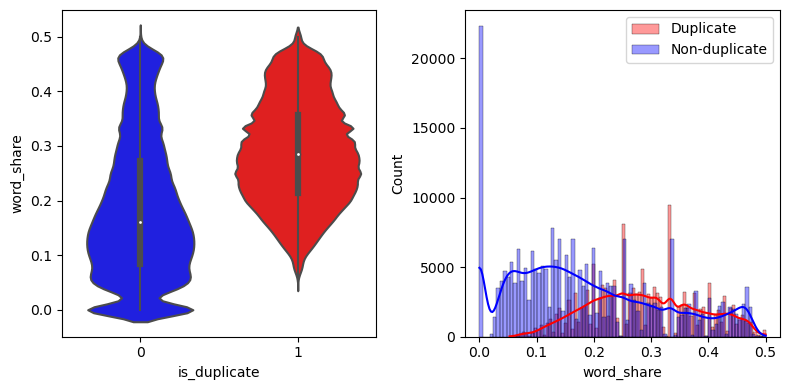

In [201]:
# plotting the relation between dulicate and word_share
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data,palette=['blue','red'])
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_share'],alpha = 0.4,color='red',kde=True, label='Duplicate')
sns.histplot(data[data['is_duplicate'] == 0]['word_share'],alpha = 0.4,color='blue',kde=True, label='Non-duplicate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_share.png'), dpi=450)
plt.show()

### Plotting Word Clouds
#### Motivation for Word Clouds
We predicted that Duplicated Questions are likely to contain many unique words. In that sense, plotting Word Clouds help us to grasp some important words or features behind the large dataset. 

### Text Preprocessing
As a part of text preprocessing, we performed the following steps:

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [202]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    porter = PorterStemmer()    #apply stemming  for example, "cats" and "catlike" are reduced to "cat"
    pattern = re.compile('\W')  #remove special characters(non-word characters)
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x) # replace special characters with space
    
    if type(x) == type(''): 
        x = porter.stem(x)
        example1 = BeautifulSoup(x) # remove html tags
        x = example1.get_text()
               
    return x

In [203]:
data["question1"] = data["question1"].apply(preprocess)
data["question2"] = data["question2"].apply(preprocess)

In [204]:
# save the data to csv file
data.to_csv("../data/data_after_text_preprocessing.csv", index=False)

In [205]:
data = pd.read_csv('../data/data_after_text_preprocessing.csv')
print(data.shape)
data.head()

(404287, 9)


,id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10.0,23.0,0.434783
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4.0,20.0,0.200000
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,4.0,24.0,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.0,19.0,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,2.0,20.0,0.100000


In [206]:
data.isnull().sum() # check for null values after preprocessing

id               0
qid1             0
qid2             0
question1       14
question2        4
is_duplicate     0
word_common      0
word_total       0
word_share       0
dtype: int64

In [207]:
data = data.dropna() # drop the null values after preprocessing
print(data.shape)

(404269, 9)


In [208]:
data_duplicate = data[data['is_duplicate'] == 1]
data_nonduplicate = data[data['is_duplicate'] == 0]

In the duplicated quesions, we combined the two questions into one question using `np.dstack`.
After that, we converted the 3D array into a 1D array using `np.flatten`. Similarly, in the non-duplicatd quesions, we went though the same process.

In [209]:
sent_dup =np.dstack([data_duplicate['question1'].values,data_duplicate['question2'].values])
print(sent_dup[0])
print(sent_dup.shape)
words_dup = sent_dup.flatten() # flatten the array
print(words_dup[0])
print(words_dup.shape)
sent_ndup =np.dstack((data_nonduplicate['question1'].values,data_nonduplicate['question2'].values))
words_ndup = sent_ndup.flatten() # flatten the array

[['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me '
  'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ']
 ['how can i be a good geologist '
  'what should i do to be a great geologist ']
 ['how do i read and find my youtube comments '
  'how can i see all my youtube comments ']
 ...
 ['how does a long distance relationship work '
  'how are long distance relationships maintained ']
 ['what does jainism say about homosexuality '
  'what does jainism say about gays and homosexuality ']
 ['do you believe there is life after death '
  'is it true that there is life after death ']]
(1, 149263, 2)
astrology  i am a capricorn sun cap moon and cap rising   what does that say about me 
(298526,)


In [210]:
textp_w = words_dup
textn_w = words_ndup
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

textp_w = [str(i) for i in textp_w] # convert the list of words in Duplicated questions to string
textn_w = [str(i) for i in textn_w] # convert the list of words in Non-Duplicate questions to string
print(textn_w[0]) 
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)
print(textn_w[:100]) # print the first 100 characters of the string

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510012
what is the step by step guide to invest in share market in india 
what is the step by step guide to invest in share market in india what is the step by step guide to 


### Word cloud for duplicate pair of questions

Word Cloud for Duplicate Question pairs


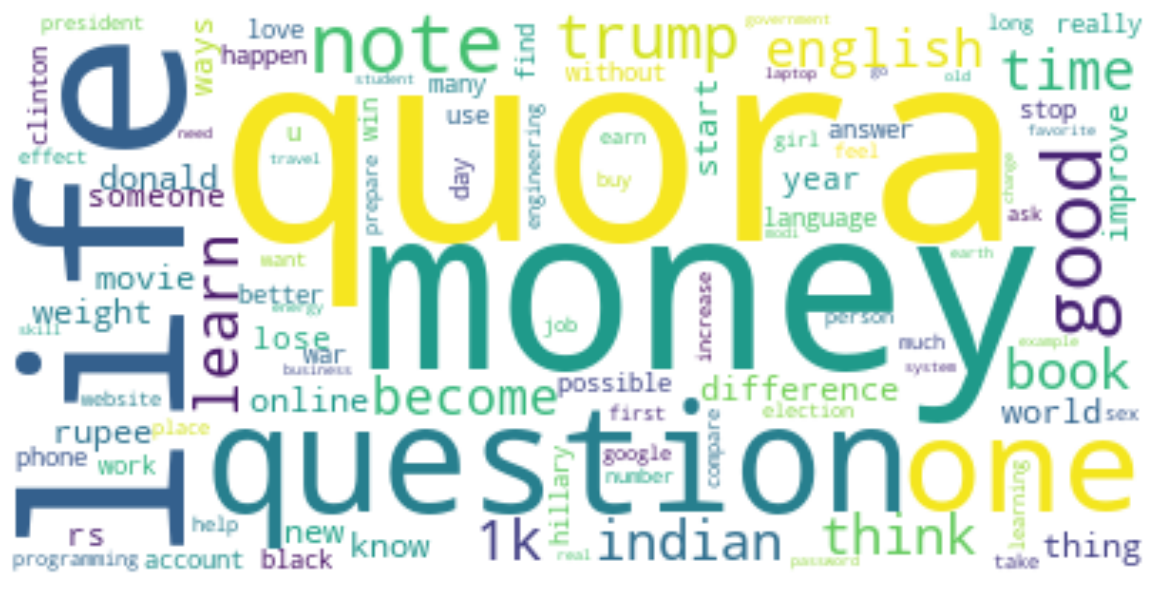

In [211]:
stopwords = set(STOPWORDS)
my_additional_stopwords = ['best','india','will','way','people','make']
stopwords.update(my_additional_stopwords)
wc = WordCloud(background_color="white", max_words= 100, stopwords=stopwords,collocations=False)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_duplicate_pair.png'), dpi=450)
plt.show()

### Word cloud for non duplicate pair of questions

Word Cloud for Non Duplicate Question pairs


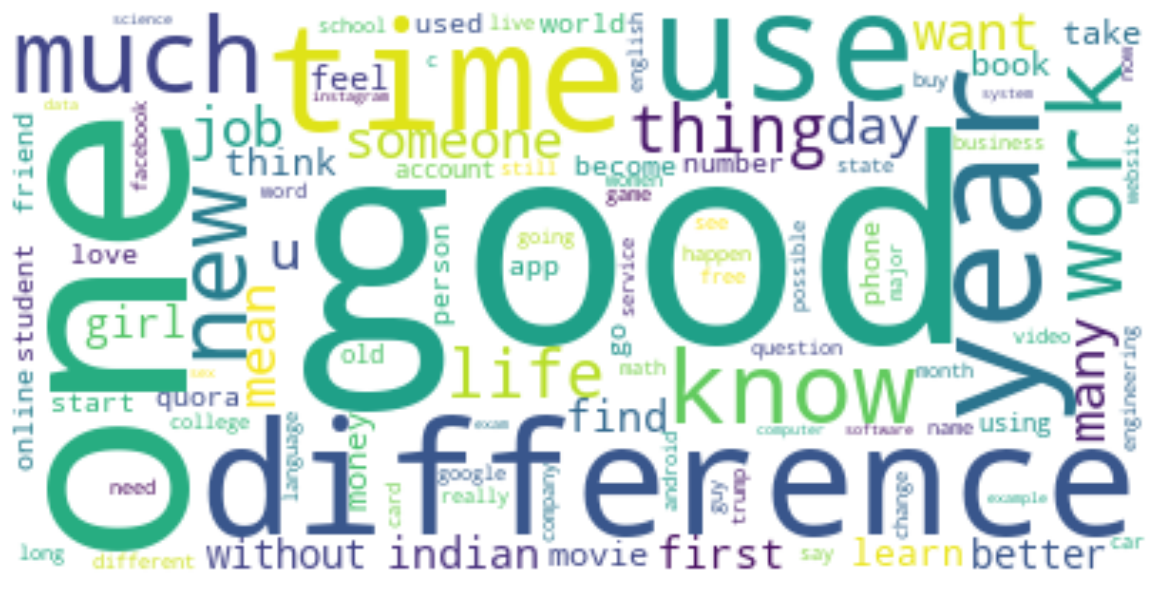

In [212]:
wc = WordCloud(background_color="white", max_words= 100, stopwords=stopwords, collocations=False)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_non_duplicate_pair.png'), dpi=450)
plt.show()